In [14]:
import json
import requests
import pandas as pd

__Using the api_call function to create the 5 Json files__

In [173]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'


#Params for access-site: desktop
desktop_site_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2016080100"
                    }

#Params for access-site: mobile
mobile_site_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2016080100"
                    }

#Params for access: desktop
desktop_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019090100'
                        }

#Params for access: mobile-app
mobile_app_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019090100'
                        }


#Params for access: mobile-web
mobile_web_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2019090100'
                        }

headers = {
    'User-Agent': 'https://github.com/yashkale94',
    'From': 'yashkale@uw.edu'
}

def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

#Creating the 5 json files
desktop_site_legacy_json = api_call(endpoint_legacy, desktop_site_legacy)
mobile_site_legacy_json = api_call(endpoint_legacy, mobile_site_legacy)

desktop_pageviews_json = api_call(endpoint_pageviews, desktop_pageviews)
mobile_app_pageviews_json = api_call(endpoint_pageviews, mobile_app_pageviews)
mobile_web_pageviews_json = api_call(endpoint_pageviews, mobile_web_pageviews)


__Dumping the api_call outputs to json files__

In [174]:
with open('pagecounts_desktop-site_200801-201607.json','w') as f:
    json.dump(desktop_site_legacy_json, f)
    
with open('pagecounts_mobile-site_200801-201607.json','w') as f:
    json.dump(mobile_site_legacy_json, f)
    
with open('pageviews_desktop_201507-201908.json', 'w') as f:
    json.dump(desktop_pageviews_json, f)
    
with open('pageviews_mobile-app_201507-201908.json', 'w') as f:
    json.dump(mobile_app_pageviews_json, f)
    
with open('pageviews_mobile-web_201507-201908.json', 'w') as f:
    json.dump(mobile_web_pageviews_json, f)


__Data Processing:1)Combining the mobile-app and mobile-web views for pageview into a single count.
2)Extracting the YYYY and MM timestamp from the json files__
    

In [175]:
pageviews_mobile = []
pageviews_desktop = []

pagecounts_mobile = []
pagecounts_desktop = []

#Creating a list of pageviews on mobile
for i in range(len(mobile_app_pageviews_json['items'])):
    app_views = mobile_app_pageviews_json['items'][i]['views']
    web_views = mobile_web_pageviews_json['items'][i]['views']
    
    timestamp = mobile_app_pageviews_json['items'][i]['timestamp']
    pageviews_mobile.append((timestamp[0:4], timestamp[4:6],app_views + web_views))

#Creating a list of pageviews on desktop
for i in range(len(desktop_pageviews_json['items'])):
    
    desktop_views = desktop_pageviews_json['items'][i]['views']
    timestamp = desktop_pageviews_json['items'][i]['timestamp']
    pageviews_desktop.append((timestamp[0:4], timestamp[4:6], desktop_views))

#Creating a list of pagecounts on mobile
for j in range(len(mobile_site_legacy_json['items'])):
    
    mobile_views = mobile_site_legacy_json['items'][j]['count']
    
    timestamp = mobile_site_legacy_json['items'][j]['timestamp']
    
    pagecounts_mobile.append((timestamp[0:4], timestamp[4:6], mobile_views))

#Creating a list of pagecounts on desktop
for j in range(len(desktop_site_legacy_json['items'])):
    
    desktop_views = desktop_site_legacy_json['items'][j]['count']
    
    timestamp = desktop_site_legacy_json['items'][j]['timestamp']
    
    pagecounts_desktop.append((timestamp[0:4], timestamp[4:6], desktop_views))
    

    

dates = pd.date_range(start='1/1/2008', end='9/1/2019',freq='M')

#Creating an empty dataframe to store all the values
df = pd.DataFrame(columns = ['y','m','year','month','pagecount_all_views','pagecount_desktop_views',
                            'pagecount_mobile_views','pageview_all_views','pageview_desktop_views'
                            ,'pageview_mobile_views'])

#Creating the required dates in the dataframe
for date in dates:
    df = df.append({'y' : date.year , 'm' : date.month}, ignore_index=True)

#Looping over pagecounts using desktop and adding at the required cell in the dataframe
for i in pagecounts_desktop:
    index = df.loc[(df['y'] == float(i[0])) & (df['m'] == float(i[1]))].index[0]
    df.loc[index,'pagecount_desktop_views'] = i[2]
    df.loc[index,'year'] = i[0]
    df.loc[index,'month'] = i[1]

#Looping over pagecounts using mobile and adding at the required cell in the dataframe
for i in pagecounts_mobile:
    index = df.loc[(df['y'] == float(i[0])) & (df['m'] == float(i[1]))].index[0]
    df.loc[index,'pagecount_mobile_views'] = i[2]
    df.loc[index,'year'] = i[0]
    df.loc[index,'month'] = i[1]

#Looping over pageviews using mobile and adding at the required cell in the dataframe
for i in pageviews_mobile:
    index = df.loc[(df['y'] == float(i[0])) & (df['m'] == float(i[1]))].index[0]
    df.loc[index,'pageview_mobile_views'] = i[2]
    df.loc[index,'year'] = i[0]
    df.loc[index,'month'] = i[1]

#Looping over pageviews using desktop and adding at the required cell in the dataframe
for i in pageviews_desktop:
    index = df.loc[(df['y'] == float(i[0])) & (df['m'] == float(i[1]))].index[0]
    df.loc[index,'pageview_desktop_views'] = i[2]
    df.loc[index,'year'] = i[0]
    df.loc[index,'month'] = i[1]

#Fill the values which are null with 0
df.fillna(0, inplace=True)

#Populating the mobile+desktop views columns in the dataframe
df['pagecount_all_views'] = df['pagecount_desktop_views'] + df['pagecount_mobile_views']
df['pageview_all_views'] = df['pageview_desktop_views'] + df['pageview_mobile_views']

df.drop(columns=['y','m'], inplace=True)

#Dumping the results to a csv file
df.to_csv('en-wikipedia_traffic_200801-201908.csv')

__Generating a timestamp column to use while plotting__

In [190]:
years = df['year']
months = df['month']

y_m = []

#Generating a timestamp column to use while plotting
for i in range(len(years)):
    y_m.append(pd.to_datetime(years[i]+months[i], format='%Y%m'))
    
df['dates'] = y_m

In [191]:
df.head()


,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,dates
0,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0,2008-01-01
1,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0,2008-02-01
2,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0,2008-03-01
3,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0,2008-04-01
4,2008,05,5.584691e+09,5.584691e+09,0.0,0.0,0.0,0.0,2008-05-01


__Plotting the dataframe__

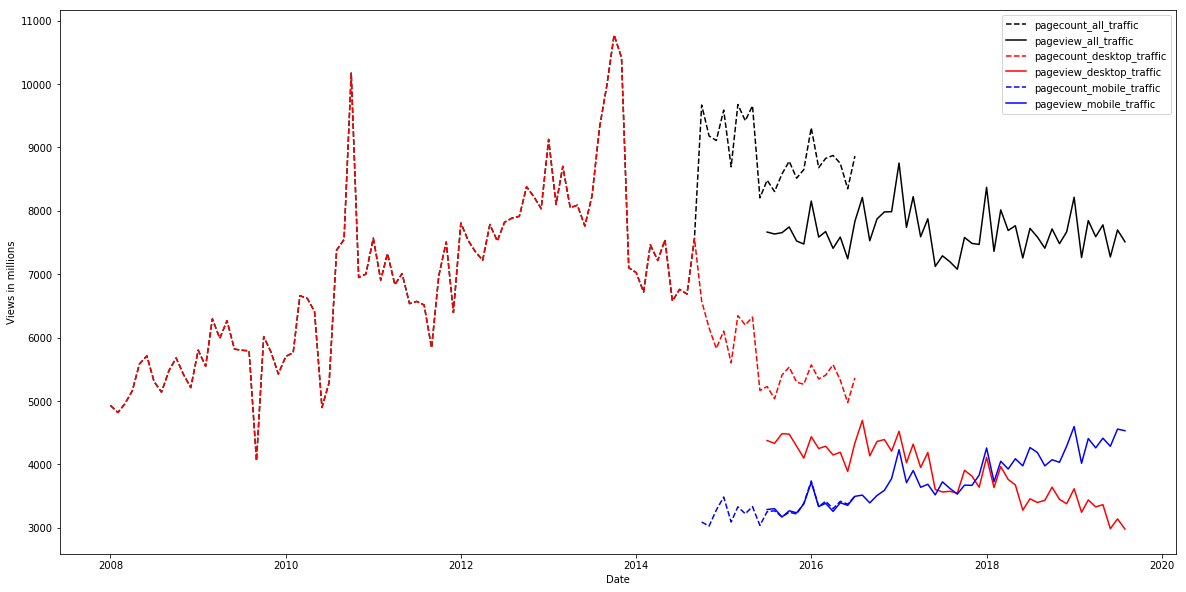

In [211]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20,10]
#PLotting the first plot
df_plot = df[df['pagecount_all_views'] > 0]
plt.plot(df_plot['dates'], df_plot['pagecount_all_views']/10**6, '--', color = 'black')

df_plot = df[df['pageview_all_views'] > 0]
plt.plot(df_plot['dates'], df_plot['pageview_all_views']/10**6, color = 'black')

df_plot = df[df['pagecount_desktop_views'] > 0]
plt.plot(df_plot['dates'], df_plot['pagecount_desktop_views']/10**6, '--', color = 'red')

df_plot = df[df['pageview_desktop_views'] > 0]
plt.plot(df_plot['dates'], df_plot['pageview_desktop_views']/10**6, color = 'red')

df_plot = df[df['pagecount_mobile_views'] > 0]
plt.plot(df_plot['dates'], df_plot['pagecount_mobile_views']/10**6, '--', color = 'blue')

df_plot = df[df['pageview_mobile_views'] > 0]
plt.plot(df_plot['dates'], df_plot['pageview_mobile_views']/10**6, color = 'blue')


plt.legend(['pagecount_all_traffic','pageview_all_traffic','pagecount_desktop_traffic',
            'pageview_desktop_traffic','pagecount_mobile_traffic','pageview_mobile_traffic',''])
plt.ylabel('Views in millions')
plt.xlabel('Date')
plt.savefig('en-wikipedia_traffic_200801-201908.png')